In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import os
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15376, done.
remote: Total 15376 (delta 0), reused 0 (delta 0), pack-reused 15376
Receiving objects: 100% (15376/15376), 13.98 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (10341/10341), done.


In [4]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [5]:
# import tensorflow as tf

# tf.config.list_physical_devices('GPU')
# # tf.test.gpu_device_name()

In [6]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [7]:
os.getcwd()

'/content/darknet'

In [8]:
!cp "/content/drive/MyDrive/DeepSOCIAL/DeepSocial.weights" -r "/content/darknet"
!cp "/content/drive/MyDrive/DeepSOCIAL/sort.py" -r "/content/darknet"
!cp "/content/drive/MyDrive/DeepSOCIAL/deepsocial.pyc" -r "/content/darknet"

In [9]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov4.cfg", "cfg/coco.data", "DeepSocial.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

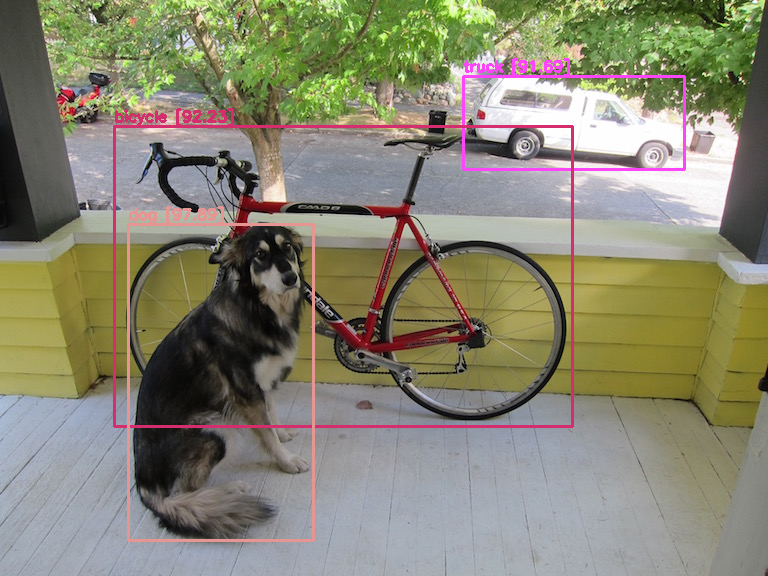

In [10]:
# run test on dog.jpg image that comes with repository
image = cv2.imread("data/dog.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

In [11]:
!pip install filterpy
from sort import *
mot_tracker    = Sort(max_age=25, min_hits=4, iou_threshold=0.3)

     |████████████████████████████████| 177 kB 4.4 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=c6e459c8d8f22f8efafe6bc6f3ceb1f0d8979005667c037b966deb051c4518c1
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built filterpy


In [12]:
from deepsocial import *

######################## Frame number
StartFrom  = 0 
EndAt      = 500                       #-1 for the end of the video
######################## (0:OFF/ 1:ON) Outputs
CouplesDetection    = 1                # Enable Couple Detection 
DTC                 = 1                # Detection, Tracking and Couples 
SocialDistance      = 1
CrowdMap            = 1
# MoveMap             = 0
# ViolationMap        = 0             
# RiskMap             = 0
######################## Units are Pixel
ViolationDistForIndivisuals = 28 
ViolationDistForCouples     = 31
####
CircleradiusForIndivsual    = 14
CircleradiusForCouples      = 17
######################## 
MembershipDistForCouples    = (16 , 10) # (Forward, Behind) per Pixel
MembershipTimeForCouples    = 35        # Time for considering as a couple (per Frame)
######################## (0:OFF/ 1:ON)
CorrectionShift  = 1                    # Ignore people in the margins of the video
HumanHeightLimit = 200                  # Ignore people with unusual heights
########################
Transparency        = 0.7
ReductionFactor     = 2
calibration         = [[180,162],[618,0],[552,540],[682,464]]

In [13]:
def extract_humans(detections):
    detetcted = []
    if len(detections) > 0: # At least 1 detection in the image and check detection presence in a frame  
        idList = []
        id = 0
        for label, confidence, bbox in detections:
            if label == 'person': 
                xmin, ymin, xmax, ymax = bbox2points(bbox)
                id +=1
                if id not in idList: idList.append(id)
                detetcted.append([int(xmin), int(ymin), int(xmax), int(ymax), idList[-1]])
    return np.array(detetcted)

def centroid(detections, image, calibration, _centroid_dict, CorrectionShift, HumanHeightLimit):
    e = birds_eye(image.copy(), calibration)
    centroid_dict = dict()
    coordinates = dict()
    now_present = list()
    if len(detections) > 0:   
        for d in detections:
            p = int(d[4])
            now_present.append(p)
            xmin, ymin, xmax, ymax = d[0], d[1], d[2], d[3]
            w = xmax - xmin
            h = ymax - ymin
            x = xmin + w/2
            y = ymax - h/2
            if h < HumanHeightLimit:
                overley = e.image
                bird_x, bird_y = e.projection_on_bird((x, ymax))
                if CorrectionShift:
                    if checkupArea(overley, 1, 0.25, (x, ymin)):
                        continue
                e.setImage(overley)
                center_bird_x, center_bird_y = e.projection_on_bird((x, ymin))
                centroid_dict[p] = (
                            int(bird_x), int(bird_y),
                            int(x), int(ymax), 
                            int(xmin), int(ymin), int(xmax), int(ymax),
                            int(center_bird_x), int(center_bird_y))

                _centroid_dict[p] = centroid_dict[p]
                coordinates[p] = (
                    int(w), int(h), int(x), int(y)
                )
    return _centroid_dict, centroid_dict, e.image, coordinates

def ColorGenerator(seed=1, size=10):
    np.random.seed = seed
    color=dict()
    for i in range(size):
        h = int(np.random.uniform() *255)
        color[i]= h
    return color

def VisualiseResult(_Map, e):
    Map = np.uint8(_Map)
    histMap = e.convrt2Image(Map)
    visualBird = cv2.applyColorMap(np.uint8(_Map), cv2.COLORMAP_JET)
    visualMap = e.convrt2Image(visualBird)
    visualShow = cv2.addWeighted(e.original, 0.7, visualMap, 1 - 0.7, 0)
    return visualShow, visualBird, histMap

In [14]:
import glob
import shutil
import pathlib

np.seterr(divide='ignore', invalid='ignore')

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]

def remove_suffix(text, prefix):
    if text.endswith(prefix):
        return text[:len(text)-len(prefix)]

source = '/content/drive/MyDrive/DeepSOCIAL/data'
dest = '/content/darknet'

for f in glob.glob('/content/drive/MyDrive/DeepSOCIAL/Video by realsense_speed up.mp4'):
  shutil.copy2(f,dest)
  input = remove_prefix(f, '/content/drive/MyDrive/DeepSOCIAL/')
  output = remove_suffix(input, '.mp4')

  Path_For_DTC = "/content/drive/MyDrive/DeepSOCIAL/Output/DTC_" + output + ".avi"
  Path_For_CrowdMap = "/content/drive/MyDrive/DeepSOCIAL/Output/Crowd-Map_" + output + ".avi"
  Path_For_SocialDistance = "/content/drive/MyDrive/DeepSOCIAL/Output/Social-Distancing_" + output + ".avi"

  # Path_For_DTC = "/content/drive/MyDrive/DeepSOCIAL/Output/DTC_" + output + ".mp4"
  # Path_For_CrowdMap = "/content/drive/MyDrive/DeepSOCIAL/Output/Crowd-Map_" + output + ".mp4"
  # Path_For_SocialDistance = "/content/drive/MyDrive/DeepSOCIAL/Output/Social-Distancing_" + output + ".mp4"

  cap = cv2.VideoCapture("./"+input)
  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))
  EndAt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  height, width = frame_height // ReductionFactor, frame_width // ReductionFactor
  print("Video Reolution: ",(width, height))

  if DTC: DTCVid = cv2.VideoWriter(Path_For_DTC, cv2.VideoWriter_fourcc(*"MJPG"), 30.0, (width, height))
  if SocialDistance: SDimageVid = cv2.VideoWriter(Path_For_SocialDistance, cv2.VideoWriter_fourcc(*"MJPG"), 30.0, (width, height))
  if CrowdMap: CrowdVid = cv2.VideoWriter(Path_For_CrowdMap, cv2.VideoWriter_fourcc(*"XVID"), 30.0, (width, height))

  # if DTC: DTCVid = cv2.VideoWriter(Path_For_DTC, cv2.VideoWriter_fourcc(*"MP4V"), 30.0, (width, height))
  # if SocialDistance: SDimageVid = cv2.VideoWriter(Path_For_SocialDistance, cv2.VideoWriter_fourcc(*"MP4V"), 30.0, (width, height))
  # if CrowdMap: CrowdVid = cv2.VideoWriter(Path_For_CrowdMap, cv2.VideoWriter_fourcc(*"MP4V"), 30.0, (width, height))

  colorPool = ColorGenerator(size = 3000)
  _centroid_dict = dict()
  _numberOFpeople = list()
  _greenZone = list()
  _redZone = list()
  _yellowZone = list()
  _final_redZone = list()
  _relation = dict()
  _couples = dict()
  _trackMap = np.zeros((height, width, 3), dtype=np.uint8)
  _crowdMap = np.zeros((height, width), dtype=np.int) 
  _allPeople = 0
  _counter = 1
  frame = 0
  

  while True:
    print('-- Frame : {}'.format(frame))
    prev_time = time.time()
    ret, frame_read = cap.read()
    if not ret: break

    frame += 1
    if frame <= StartFrom: continue
    if frame != -1:
        if frame > EndAt: break
        
    frame_resized = cv2.resize(frame_read,(width, height), interpolation=cv2.INTER_LINEAR)
    image = frame_resized
    e = birds_eye(image, calibration)
    detections, width_ratio, height_ratio = darknet_helper(image, width, height)
    humans = extract_humans(detections)
    track_bbs_ids = mot_tracker.update(humans) if len(humans) != 0 else humans

    _centroid_dict, centroid_dict, partImage, coordinates = centroid(track_bbs_ids, image, calibration, _centroid_dict, CorrectionShift, HumanHeightLimit)
    ###
    print(coordinates)
    ###
    redZone, greenZone = find_zone(centroid_dict, _greenZone, _redZone, criteria=ViolationDistForIndivisuals)
    
    if CouplesDetection:
        _relation, relation = find_relation(e, centroid_dict, MembershipDistForCouples, redZone, _couples, _relation)
        _couples, couples, coupleZone = find_couples(image, _centroid_dict, relation, MembershipTimeForCouples, _couples)
        yellowZone, final_redZone, redGroups = find_redGroups(image, centroid_dict, calibration, ViolationDistForCouples, redZone, coupleZone, couples , _yellowZone, _final_redZone)
    else:
        couples = []
        coupleZone = []
        yellowZone = []
        redGroups = redZone
        final_redZone = redZone


    if DTC:
        DTC_image = image.copy()
        _trackMap = Apply_trackmap(centroid_dict, _trackMap, colorPool, 3)
        DTC_image = cv2.add(e.convrt2Image(_trackMap), image) 
        DTCShow = DTC_image
        for id, box in centroid_dict.items():
            center_bird = box[0], box[1]
            if not id in coupleZone:
                cv2.rectangle(DTCShow,(box[4], box[5]),(box[6], box[7]),(0,255,0),2)
                cv2.rectangle(DTCShow,(box[4], box[5]-13),(box[4]+len(str(id))*10, box[5]),(0,200,255),-1)
                cv2.putText(DTCShow,str(id),(box[4]+2, box[5]-2),cv2.FONT_HERSHEY_SIMPLEX,.4,(0,0,0),1,cv2.LINE_AA)
        for coupled in couples:
            p1 , p2 = coupled
            couplesID = couples[coupled]['id']
            couplesBox = couples[coupled]['box']
            cv2.rectangle(DTCShow, couplesBox[2:4], couplesBox[4:], (0,150,255), 4)
            loc = couplesBox[0] , couplesBox[3]
            offset = len(str(couplesID)*5)
            captionBox = (loc[0] - offset, loc[1]-13), (loc[0] + offset, loc[1])
            cv2.rectangle(DTCShow,captionBox[0],captionBox[1],(0,200,255),-1)
            wc = captionBox[1][0] - captionBox[0][0]
            hc = captionBox[1][1] - captionBox[0][1]
            cx = captionBox[0][0] + wc // 2
            cy = captionBox[0][1] + hc // 2
            textLoc = (cx - offset, cy + 4)
            cv2.putText(DTCShow, str(couplesID) ,(textLoc),cv2.FONT_HERSHEY_SIMPLEX,.4,(0,0,0),1,cv2.LINE_AA)
        DTCVid.write(DTCShow)


    if SocialDistance:
        SDimage, birdSDimage = Apply_ellipticBound(centroid_dict, image, calibration, redZone, greenZone, yellowZone, final_redZone, coupleZone, couples, CircleradiusForIndivsual, CircleradiusForCouples)
        SDimageVid.write(SDimage)


    if CrowdMap:
        _crowdMap, crowdMap = Apply_crowdMap(centroid_dict, image, _crowdMap)
        crowd = (crowdMap - crowdMap.min()) / (crowdMap.max() - crowdMap.min())*255
        crowd_visualShow, crowd_visualBird, crowd_histMap = VisualiseResult(crowd, e)
        CrowdVid.write(crowd_visualShow)


    cv2.waitKey(3)
  print('::: Analysis Completed')

  cap.release()
  if DTC: DTCVid.release(); print("::: Video Write Completed : ", Path_For_DTC)
  if SocialDistance: SDimageVid.release() ; print("::: Video Write Completed : ", Path_For_SocialDistance)
  if CrowdMap: CrowdVid.release() ; print("::: Video Write Completed : ", Path_For_CrowdMap)

Video Reolution:  (640, 360)
-- Frame : 0
{}
-- Frame : 1
{}
-- Frame : 2
{}
-- Frame : 3
{}
-- Frame : 4
{}
-- Frame : 5
{}
-- Frame : 6
{}
-- Frame : 7
{}
-- Frame : 8
{}
-- Frame : 9
{}
-- Frame : 10
{}
-- Frame : 11
{}
-- Frame : 12
{}
-- Frame : 13
{}
-- Frame : 14
{}
-- Frame : 15
{}
-- Frame : 16
{1: (42, 83, 349, 42)}
-- Frame : 17
{1: (42, 88, 349, 44)}
-- Frame : 18
{}
-- Frame : 19
{}
-- Frame : 20
{}
-- Frame : 21
{}
-- Frame : 22
{1: (38, 89, 348, 49)}
-- Frame : 23
{1: (36, 93, 347, 51)}
-- Frame : 24
{1: (34, 93, 345, 50)}
-- Frame : 25
{1: (34, 95, 346, 51)}
-- Frame : 26
{1: (35, 99, 346, 52)}
-- Frame : 27
{1: (35, 101, 345, 53)}
-- Frame : 28
{1: (35, 103, 344, 54)}
-- Frame : 29
{1: (33, 103, 344, 54)}
-- Frame : 30
{1: (32, 104, 343, 59)}
-- Frame : 31
{1: (32, 104, 345, 60)}
-- Frame : 32
{1: (33, 104, 347, 63)}
-- Frame : 33
{1: (33, 104, 349, 64)}
-- Frame : 34
{1: (31, 106, 349, 69)}
-- Frame : 35
{1: (30, 106, 350, 71)}
-- Frame : 36
{1: (29, 106, 351, 72)}
--

In [15]:
import glob
import shutil
import pathlib

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]

def remove_suffix(text, prefix):
    if text.endswith(prefix):
        return text[:len(text)-len(prefix)]

source = '/content/drive/MyDrive/DeepSOCIAL/data'
dest = '/content/darknet'

for f in glob.glob('/content/drive/MyDrive/DeepSOCIAL/data/*.mp4'):
  shutil.copy2(f,dest)
  input = remove_prefix(f, '/content/drive/MyDrive/DeepSOCIAL/data/')
  output = remove_suffix(input, '.mp4')

  Path_For_DTC = "/content/drive/MyDrive/DeepSOCIAL/Output/DTC_" + output + ".avi"
  Path_For_CrowdMap = "/content/drive/MyDrive/DeepSOCIAL/Output/Crowd-Map_" + output + ".avi"
  Path_For_SocialDistance = "/content/drive/MyDrive/DeepSOCIAL/Output/Social-Distancing_" + output + ".avi"

  cap = cv2.VideoCapture("./"+input)
  frame_width = int(cap.get(3))
  frame_height = int(cap.get(4))
  EndAt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  height, width = frame_height // ReductionFactor, frame_width // ReductionFactor
  print("Video Reolution: ",(width, height))

  if DTC: DTCVid = cv2.VideoWriter(Path_For_DTC, cv2.VideoWriter_fourcc(*"MJPG"), 30.0, (width, height))
  if SocialDistance: SDimageVid = cv2.VideoWriter(Path_For_SocialDistance, cv2.VideoWriter_fourcc(*"MJPG"), 30.0, (width, height))
  if CrowdMap: CrowdVid = cv2.VideoWriter(Path_For_CrowdMap, cv2.VideoWriter_fourcc(*"XVID"), 30.0, (width, height))

  # if DTC: DTCVid = cv2.VideoWriter(Path_For_DTC, cv2.VideoWriter_fourcc(*"MP4V"), 30.0, (width, height))
  # if SocialDistance: SDimageVid = cv2.VideoWriter(Path_For_SocialDistance, cv2.VideoWriter_fourcc(*"MP4V"), 30.0, (width, height))
  # if CrowdMap: CrowdVid = cv2.VideoWriter(Path_For_CrowdMap, cv2.VideoWriter_fourcc(*"MP4V"), 30.0, (width, height))

  colorPool = ColorGenerator(size = 3000)
  _centroid_dict = dict()
  _numberOFpeople = list()
  _greenZone = list()
  _redZone = list()
  _yellowZone = list()
  _final_redZone = list()
  _relation = dict()
  _couples = dict()
  _trackMap = np.zeros((height, width, 3), dtype=np.uint8)
  _crowdMap = np.zeros((height, width), dtype=np.int) 
  _allPeople = 0
  _counter = 1
  frame = 0


  while True:
    print('-- Frame : {}'.format(frame))
    prev_time = time.time()
    ret, frame_read = cap.read()
    if not ret: break

    frame += 1
    if frame <= StartFrom: continue
    if frame != -1:
        if frame > EndAt: break
        
    frame_resized = cv2.resize(frame_read,(width, height), interpolation=cv2.INTER_LINEAR)
    image = frame_resized
    e = birds_eye(image, calibration)
    detections, width_ratio, height_ratio = darknet_helper(image, width, height)
    humans = extract_humans(detections)
    track_bbs_ids = mot_tracker.update(humans) if len(humans) != 0 else humans

    _centroid_dict, centroid_dict, partImage, coordinates = centroid(track_bbs_ids, image, calibration, _centroid_dict, CorrectionShift, HumanHeightLimit)
    ###
    print(coordinates)
    ###
    redZone, greenZone = find_zone(centroid_dict, _greenZone, _redZone, criteria=ViolationDistForIndivisuals)
    
    if CouplesDetection:
        _relation, relation = find_relation(e, centroid_dict, MembershipDistForCouples, redZone, _couples, _relation)
        _couples, couples, coupleZone = find_couples(image, _centroid_dict, relation, MembershipTimeForCouples, _couples)
        yellowZone, final_redZone, redGroups = find_redGroups(image, centroid_dict, calibration, ViolationDistForCouples, redZone, coupleZone, couples , _yellowZone, _final_redZone)
    else:
        couples = []
        coupleZone = []
        yellowZone = []
        redGroups = redZone
        final_redZone = redZone


    if DTC:
        DTC_image = image.copy()
        _trackMap = Apply_trackmap(centroid_dict, _trackMap, colorPool, 3)
        DTC_image = cv2.add(e.convrt2Image(_trackMap), image) 
        DTCShow = DTC_image
        for id, box in centroid_dict.items():
            center_bird = box[0], box[1]
            if not id in coupleZone:
                cv2.rectangle(DTCShow,(box[4], box[5]),(box[6], box[7]),(0,255,0),2)
                cv2.rectangle(DTCShow,(box[4], box[5]-13),(box[4]+len(str(id))*10, box[5]),(0,200,255),-1)
                cv2.putText(DTCShow,str(id),(box[4]+2, box[5]-2),cv2.FONT_HERSHEY_SIMPLEX,.4,(0,0,0),1,cv2.LINE_AA)
        for coupled in couples:
            p1 , p2 = coupled
            couplesID = couples[coupled]['id']
            couplesBox = couples[coupled]['box']
            cv2.rectangle(DTCShow, couplesBox[2:4], couplesBox[4:], (0,150,255), 4)
            loc = couplesBox[0] , couplesBox[3]
            offset = len(str(couplesID)*5)
            captionBox = (loc[0] - offset, loc[1]-13), (loc[0] + offset, loc[1])
            cv2.rectangle(DTCShow,captionBox[0],captionBox[1],(0,200,255),-1)
            wc = captionBox[1][0] - captionBox[0][0]
            hc = captionBox[1][1] - captionBox[0][1]
            cx = captionBox[0][0] + wc // 2
            cy = captionBox[0][1] + hc // 2
            textLoc = (cx - offset, cy + 4)
            cv2.putText(DTCShow, str(couplesID) ,(textLoc),cv2.FONT_HERSHEY_SIMPLEX,.4,(0,0,0),1,cv2.LINE_AA)
        DTCVid.write(DTCShow)


    if SocialDistance:
        SDimage, birdSDimage = Apply_ellipticBound(centroid_dict, image, calibration, redZone, greenZone, yellowZone, final_redZone, coupleZone, couples, CircleradiusForIndivsual, CircleradiusForCouples)
        SDimageVid.write(SDimage)


    if CrowdMap:
        _crowdMap, crowdMap = Apply_crowdMap(centroid_dict, image, _crowdMap)
        crowd = (crowdMap - crowdMap.min()) / (crowdMap.max() - crowdMap.min())*255
        crowd_visualShow, crowd_visualBird, crowd_histMap = VisualiseResult(crowd, e)
        CrowdVid.write(crowd_visualShow)


    cv2.waitKey(3)
  print('::: Analysis Completed')

  cap.release()
  if DTC: DTCVid.release(); print("::: Video Write Completed : ", Path_For_DTC)
  if SocialDistance: SDimageVid.release() ; print("::: Video Write Completed : ", Path_For_SocialDistance)
  if CrowdMap: CrowdVid.release() ; print("::: Video Write Completed : ", Path_For_CrowdMap)

Streaming output truncated to the last 5000 lines.
{120: (41, 94, 940, 434), 119: (50, 99, 886, 325)}
-- Frame : 453
{120: (41, 94, 940, 435), 119: (52, 99, 887, 325)}
-- Frame : 454
{120: (40, 94, 940, 436), 119: (53, 98, 887, 325)}
-- Frame : 455
{120: (40, 91, 940, 440), 119: (55, 98, 888, 325)}
-- Frame : 456
{120: (39, 94, 941, 435), 119: (57, 98, 889, 325)}
-- Frame : 457
{119: (58, 97, 889, 324)}
-- Frame : 458
{119: (60, 97, 893, 325)}
-- Frame : 459
{119: (61, 97, 898, 325)}
-- Frame : 460
{119: (60, 97, 899, 325)}
-- Frame : 461
{119: (59, 97, 900, 325)}
-- Frame : 462
{119: (59, 96, 902, 325)}
-- Frame : 463
{119: (56, 95, 904, 325)}
-- Frame : 464
{119: (54, 95, 909, 325)}
-- Frame : 465
{119: (52, 94, 913, 325)}
-- Frame : 466
{119: (50, 94, 915, 325)}
-- Frame : 467
{119: (50, 94, 916, 327)}
-- Frame : 468
{119: (52, 95, 916, 327)}
-- Frame : 469
{119: (54, 96, 918, 328)}
-- Frame : 470
{119: (56, 96, 919, 328)}
-- Frame : 471
{119: (58, 96, 920, 328)}
-- Frame : 472
{119